In [2]:
import pandas as pd
from epiweeks import Week
from mosqlient import upload_prediction
from mosqlient.forecast import Arima

# Creating a simple forecasting model
The Mosqlient library already includes a simple forecasting model for demonstrative purposes based on an ARIMA model.

## Downloading the Dengue dataset

Here we will build a simple univariate model using only dengue cases. We could use the Mosqlient library to fetch the data straight from the API, but instead we will download the prepared datasets made available by the sprint organizers. 

We will apply this model to the `MG` state.

In [3]:
df = pd.read_csv('dengue.csv.gz')

df = df.loc[df.uf == 'MG']

df['date'] = [Week.fromstring(str(x)).startdate() for x in df.epiweek]

df['date'] = pd.to_datetime(df['date'])

df.set_index('date', inplace = True)

df.head()

,year,epiweek,casos,geocode,regional,regional_geocode,macroregional,macroregional_geocode,uf,train_1,train_2,target_1,target_2
date,,,,,,,,,,,,,
2010-01-03,2010,201001,0,3110806,Itambacuri,31096,Nordeste,3111,MG,True,True,False,False
2010-01-03,2010,201001,0,3132404,Itajubá,31003,Sul,3101,MG,True,True,False,False
2010-01-03,2010,201001,0,3168903,São Gotardo,31082,Noroeste,3109,MG,True,True,False,False
2010-01-03,2010,201001,0,3155405,Juiz de Fora,31097,Sudeste,3107,MG,True,True,False,False
2010-01-03,2010,201001,0,3170602,Piumhi,31093,Sul,3101,MG,True,True,False,False


To apply the ARIMA baseline model, it is necessary to rename the target column to `y` and use the `dates` column as the index. For more information about the `ARIMA` model look at this [example](https://github.com/Mosqlimate-project/mosqlimate-client/blob/main/docs/tutorials/baseline_model.ipynb). 

In [4]:
df = df[['casos']]

df = df.resample('W').sum()

df = df.rename(columns = {'casos': 'y'})

df.head()

,y
date,
2010-01-03,2794
2010-01-10,3729
2010-01-17,4656
2010-01-24,6195
2010-01-31,7179


Let's define and train the model:

In [5]:
m_arima = Arima(df = df)
m_arima

In [6]:
model = m_arima.train( train_ini_date='2010-01-01', train_end_date = '2021-12-31')
model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2271.469, Time=2.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2193.305, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2209.331, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2204.646, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2194.588, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2218.257, Time=1.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2243.046, Time=1.36 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-2219.479, Time=3.66 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-2256.871, Time=6.47 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2241.576, Time=1.91 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-2245.256, Time=0.67 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-2243.202, Time=2.33 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.97 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-2286.402, Time=0.90 sec
 ARIMA(1,1,2)(0,0,0)[0]  

ARIMA(maxiter=100, order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

## Making in-sample predictions

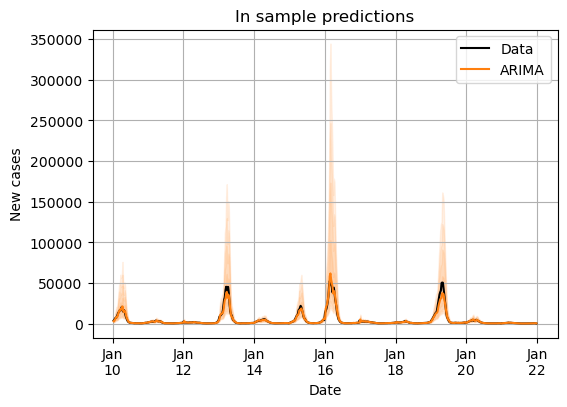

In [7]:
df_in_sample = m_arima.predict_in_sample(plot = True)

In [8]:
df_in_sample.head()

,lower_95,upper_95,lower_90,upper_90,lower_80,upper_80,lower_50,upper_50,pred,date,data
1,1526.270381,5738.507945,1671.571999,5062.539403,1861.514447,4403.200277,2244.179746,3525.618728,2794.000019,2010-01-10,3729.0
2,2040.065797,8543.767529,2248.128494,7447.100499,2522.484032,6394.123168,3082.721975,5020.756459,3903.438085,2010-01-17,4656.0
3,2521.304107,11515.565097,2791.951207,9938.488315,3151.274482,8443.662105,3892.886726,6525.907882,4996.172270,2010-01-24,6195.0
4,3282.339202,17011.851013,3659.789256,14466.198554,4165.796731,12099.270404,5226.216058,9135.738104,6839.162485,2010-01-31,7179.0
5,3721.783442,20543.982427,4163.696321,17338.456811,4758.932914,14386.952501,6015.711217,10736.561214,7948.326420,2010-02-07,7238.0


## Using the model for forecasting:

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3842.633, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-2203.217, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.69 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-2207.238, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1960.367, Time=0.24 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-2214.615, Time=0.32 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1247.750, Time=0.52 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-2253.994, Time=0.85 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=1.94 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-2254.825, Time=0.71 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-2224.777, Time=0.55 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=inf, Time=

,lower_95,upper_95,lower_90,upper_90,lower_80,upper_80,lower_50,upper_50,pred,date
0,6424.830734,61736.449230,7404.108477,48733.850771,8775.830008,37704.860762,11857.173453,25387.368637,17043.312291,2024-01-07
1,5021.055346,119998.810342,6016.965246,82918.803460,7491.253210,56245.609793,11118.552022,31629.243539,18133.487745,2024-01-14
2,4293.158401,266215.284907,5316.192262,155363.770079,6903.463080,90233.093468,11134.448550,41715.775246,20428.623930,2024-01-21
3,3864.813430,844428.236632,4947.837629,373262.512079,6711.302676,172165.026384,11829.789379,61244.895842,24779.168029,2024-01-28


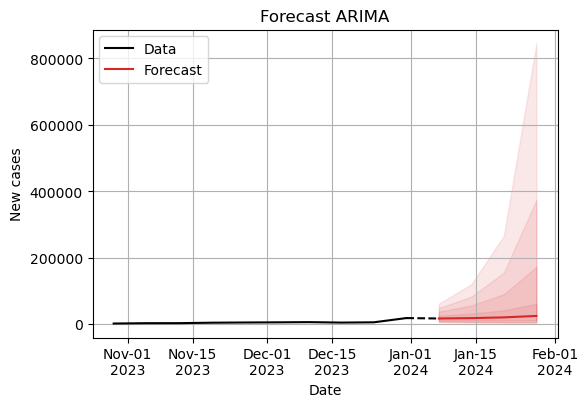

In [9]:
model = m_arima.train( train_ini_date='2010-01-01', train_end_date = '2023-12-31')
df_for = m_arima.forecast(horizon = 4, plot = True, last_obs = 10)
df_for['date']= pd.to_datetime(df_for['date'])
df_for.head()

## Uploading the forecasts to the Mosqlimate platform
Before uploading the estimates, you need to register your model on the platform. For this, you should follow [these instructions](https://api.mosqlimate.org/docs/registry/POST/models/).

Then, you can upload the forecast using the function `upload_predictions` from the `mosqlient` package. 


The function has the following parameters:

- `model_id`: int, The id number of the model registered on the platform. 
- `description`: str, A brief description of the prediction. 
- `commit`": str, The commit number associated with the model that generated the prediction.
- `predict_date`: str, The day of the prediction. 
- `prediction`: pd.DataFrame, A  dataframe that contains the data. It must contain the following columns: [`date`, `lower_95`, `upper_95`, `lower_90`, `upper_90`, `lower_80`, `upper_80`, `lower_50`, `upper_50`, `preds`, `adm_{adm_level}`].
- `api_key`: str, your personal api key. 

When registering your model, you need to provide the `ADM Level` of the output predictions. If your model has an ADM level—1, state level, then your predictions must contain the `adm_1` column. The other adm columns can be set as NA values.

Let's add the adm level in out predictions.:

In [10]:
df_for['adm_1'] = 'MG'

df_for.head()

,lower_95,upper_95,lower_90,upper_90,lower_80,upper_80,lower_50,upper_50,pred,date,adm_1
0,6424.830734,61736.449230,7404.108477,48733.850771,8775.830008,37704.860762,11857.173453,25387.368637,17043.312291,2024-01-07,MG
1,5021.055346,119998.810342,6016.965246,82918.803460,7491.253210,56245.609793,11118.552022,31629.243539,18133.487745,2024-01-14,MG
2,4293.158401,266215.284907,5316.192262,155363.770079,6903.463080,90233.093468,11134.448550,41715.775246,20428.623930,2024-01-21,MG
3,3864.813430,844428.236632,4947.837629,373262.512079,6711.302676,172165.026384,11829.789379,61244.895842,24779.168029,2024-01-28,MG


Let's import the function to send the predictions:

In [11]:
from mosqlient import upload_prediction

The code below is used since my api_key is saved on an .env file: 

In [12]:
import os
import json
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Access the environment variables
api_key = os.getenv('API_KEY')

To transform a dataframe in the json string format accepted by the function, just use the command: 

df_for.to_json(orient = 'records', date_format = 'iso')`. 

In [21]:
res = upload_prediction(
            model_id = 13, 
            description = 'test for sprint 2025 preds of the arima model in MG', 
            commit = '75ff7f81653429b6a89490b756a3ca2540a7b1b6',
            predict_date = '2025-04-11', 
            prediction = df_for,
            adm_1="MG",
            api_key = api_key)

res.text

ValueError: {"detail": "Failed to fetch commit: https://github.com/eduardocorrearaujo/teste_repo.git/commit/75ff7f81653429b6a89490b756a3ca2540a7b1b6"}

In [13]:
res.reason

'Created'

If the prediction's upload worked you will receive a json output as shown above. Also you will see it in your [predictions page](https://api.mosqlimate.org/predictions/).

The `mosqlient` package also contains a Class to compare your predictions called `Scorer`. A full documentation of the functions of this class can be found [here](https://github.com/Mosqlimate-project/mosqlimate-client/blob/main/docs/tutorials/scoring.ipynb). 

But in summary it takes as input the parameters: 
* `df_true`: pd.DataFrame. DataFrame with the columns `date` and `casos`. 
* `ids`: list[int] | None. List of the predictions already registered in the platform that you want to compare your model with. 
* `preds`: pd.DataFrame. Preds to be compared with df_true. It must contains the columns: `date`, `lower_95`, `upper_95`, `lower_90`, `upper_90`, `lower_80`, `upper_80`, `lower_50`, `upper_50`, `preds`, `adm_{adm_level}`.
  
Let's compare the `df_for` with what happened during the period. 

In [13]:
df_true = df.loc[(df.index >= '2024-01-07') & (df.index <= '2024-01-28')].rename(columns = {'y':'casos'})

df_true.reset_index(inplace = True)

df_true

,date,casos
0,2024-01-07,24030.0
1,2024-01-14,37131.0
2,2024-01-21,56826.0
3,2024-01-28,78217.0


In [14]:
df_for.dtypes

lower_95           float64
upper_95           float64
lower_90           float64
upper_90           float64
lower_80           float64
upper_80           float64
lower_50           float64
upper_50           float64
pred               float64
date        datetime64[ns]
adm_1               object
dtype: object

In [15]:
from mosqlient.scoring import Scorer

score = Scorer(api_key=api_key, df_true = df_true, pred = df_for, conf_level=0.90)

Let's see a plot comparing the cases and predictions:

In [16]:
score.plot_predictions()

alt.LayerChart(...)

Let's see the CRPS score of the model: 

In [17]:
score.crps

({'pred': date
  2024-01-07     4232.152316
  2024-01-14    10627.610541
  2024-01-21    20456.941384
  2024-01-28    30810.278260
  dtype: float64},
 {'pred': 16531.745624956227})

In [18]:
score.plot_crps()

alt.VConcatChart(...)